# TrainCNN for Food Classification(EfficientNetB4)_FreezModel_No-ClassImbalance

In [2]:
# Display nvidia gpu
!nvidia-smi

Thu Jun 13 11:07:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   29C    P8               3W / 165W |    714MiB / 16380MiB |     22%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# import libs
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Check image in the dataset

In [5]:
from pathlib import Path
import imghdr
import os
import tensorflow as tf
from tensorflow import image
from PIL import Image

data_dir = "./AllFood/"
image_extensions = [".bmp", ".gif", ".jpeg", ".png"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*.webp"):
    im = Image.open(filepath)
    im.save(filepath.with_suffix(".png"))
    im.close()
    os.remove(filepath)
    print(f"{filepath} is a webp file, not accepted by TensorFlow")

for filepath in Path(data_dir).rglob("*.gif"):
    im = Image.open(filepath)
    im.save(filepath.with_suffix(".png"))
    im.close()
    os.remove(filepath)
    print(f"{filepath} is a gif file, not accepted by TensorFlow")

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            continue
               

In [6]:
import os
import cv2
import imghdr

def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'./AllFood/test/'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        os.remove(bad_file_list[i])
        print (f"{bad_file_list[i]} has been removed")
else:
    print(' no improper image files were found')

source_dir =r'./AllFood/train/'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        os.remove(bad_file_list[i])
        print (f"{bad_file_list[i]} has been removed")
else:
    print(' no improper image files were found')

processing class directory  Ba-Mee-Kiao-Ped-Yang
processing class directory  Ba-Mee-Krob-Rat-Na
processing class directory  Boiled Chicken Rice
processing class directory  Bua-Loi
processing class directory  Cherri
processing class directory  chompu
processing class directory  Kaeo-Mangkon
processing class directory  kaonaped
processing class directory  Khai-Hong
processing class directory  Khanom-Jeen-Kaeng-Khiao-Wan-Kai
processing class directory  Khanom-Jeen-Nam-Ngiao
processing class directory  Khanom-Khuai
processing class directory  Khanom-Phing
processing class directory  Khanta-Lup
processing class directory  Khao-Phod
processing class directory  Khao-Soi-Kai
processing class directory  Khao-Soi-Moo
processing class directory  Khao-Tom-Mat
processing class directory  KhaoKangKareeGai
processing class directory  KhaokapraomoosubKhaiDow
processing class directory  KhaoKhaiJeow
processing class directory  KhaoKhaMoo
processing class directory  KhaoKlukKapi
processing class directo

## Define ImageSize / BatchSize for Training Model

In [7]:
img_height=380
img_width=380
batch_size=16

## Training Set DIR

In [8]:
train_dataset_path='./AllFood/train/'

## Testing Set DIR

In [9]:
test_dataset_path='./AllFood/test/'

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3116 files belonging to 52 classes.
Using 2493 files for training.


In [11]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['Ba-Mee-Kiao-Ped-Yang', 'Ba-Mee-Krob-Rat-Na', 'Boiled Chicken Rice', 'Bua-Loi', 'Cherri', 'Kaeo-Mangkon', 'Khai-Hong', 'Khanom-Jeen-Kaeng-Khiao-Wan-Kai', 'Khanom-Jeen-Nam-Ngiao', 'Khanom-Khuai', 'Khanom-Phing', 'Khanta-Lup', 'Khao-Phod', 'Khao-Soi-Kai', 'Khao-Soi-Moo', 'Khao-Tom-Mat', 'KhaoKangKareeGai', 'KhaoKhaMoo', 'KhaoKhaiJeow', 'KhaoKlukKapi', 'KhaoKrapaoMooGrob', 'KhaoKungTodKratiem', 'KhaoMooDaeng', 'KhaokapraomoosubKhaiDow', 'Klauy-Khai', 'Kluai-Buat-Chi', 'Kra-Mae', 'Kuai-Chap', 'Kuai-Tiao-Sen-Lek-Tom-Yum-Moo', 'Kuai-Tiao-Sen-Yai-Rat-Na-Kai', 'Kuai-Tiao-Tom-Yum-Kung', 'Kui-Chai-Thot', 'Malako', 'Nam-Aoi-Sai-Kaew', 'Nam-Coke-Sai-Kaew', 'Nam-Krajiab-Sai-Kaew', 'Nam-Lam-Yai-Sai-Kaew', 'Nam-Ma-Khuea-Thet-Sai-Kaew', 'Nam-Ma-Nao-Sai-Kaew', 'Nam-Ma-Tum-Sai-Kaew', 'Nam-Ngon-Sai-Kaew', 'Nam-Sapparot-Sai-Kaew', 'Nam-Som-Khan-Sai-Kaew', 'Ngao', 'Noina', 'Pa-Thong-Ko', 'Sa-Rim', 'Thurian', 'chompu', 'kaonaped', 'khaomokgai', 'khaomootod']
number of class = 52


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3116 files belonging to 52 classes.
Using 623 files for validation.


In [13]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 258 files belonging to 52 classes.


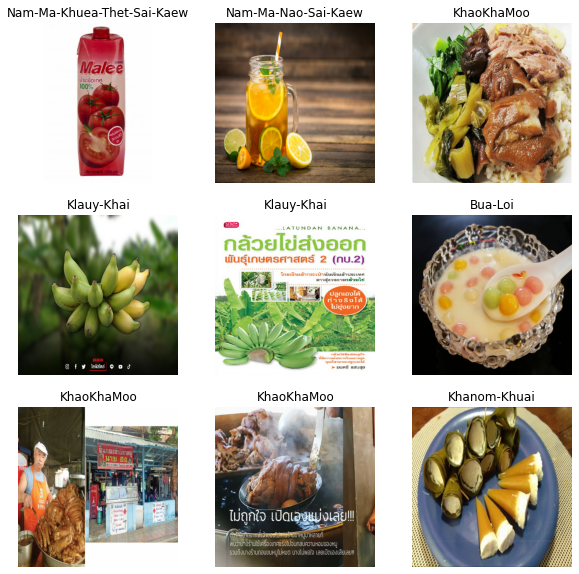

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Augmentation & Dataset Preparation

In [15]:
data_augmentation = tf.keras.Sequential([
  #layers.RandomFlip("vertical"),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.100),
  layers.RandomZoom(height_factor=0.025,width_factor=0.025),
  #layers.RandomContrast(0.300),
])

In [16]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.

  # ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE) # if using EfficientNet -> Normalize Layer will already included in the model

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

## Load Model Architecture with Transfer Learning of EfficientNetB3 from imagenet

In [18]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input,EfficientNetB4

efficientnetB4_model = keras.applications.EfficientNetB4(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

efficientnetB4_model_nooutput = efficientnetB4_model.layers[-3].output
custom_efficientnetB4_model = Model(inputs = efficientnetB4_model.input, outputs = efficientnetB4_model_nooutput)

### Freez Extractor+

In [19]:
custom_efficientnetB4_model.trainable = False
for layer in custom_efficientnetB4_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_efficientnetB4_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(custom_efficientnetB4_model, to_file="EfficientnetB4Output.png", show_shapes=True)

## Add custom Dense Layer and Dropout(Overfitting Prevention)

In [21]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_efficientnetB4_model)
# Classifier
#DeepDense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1792)              17673823  
_________________________________________________________________
dense (Dense)                (None, 1024)              1836032   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 52)                53300     
Total params: 19,563,155
Trainable params: 1,889,332
Non-trainable params: 17,673,823
_________________________________________________________________


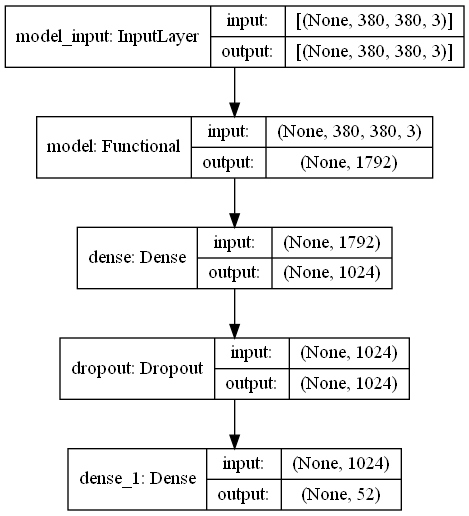

In [23]:
#print(len(model.layers))
tf.keras.utils.plot_model(model, to_file="FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

## Train Model

In [30]:
path_to_model = "./model/"

In [25]:
EPOCHS = 1000
save_model_interval = 200
checkpoint_filepath = path_to_model+'EfficientnetB4-epoch{epoch:04d}.pb' # -val_acc{val_accuracy:.2f}
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/1000
156/156 [==============================] - 56s 229ms/step - loss: 1.9243 - accuracy: 0.4874 - val_loss: 1.2426 - val_accuracy: 0.6276
Epoch 2/1000
156/156 [==============================] - 30s 194ms/step - loss: 0.7691 - accuracy: 0.7577 - val_loss: 1.0276 - val_accuracy: 0.6726
Epoch 3/1000
156/156 [==============================] - 30s 193ms/step - loss: 0.4430 - accuracy: 0.8676 - val_loss: 0.9809 - val_accuracy: 0.7239
Epoch 4/1000
156/156 [==============================] - 29s 188ms/step - loss: 0.2770 - accuracy: 0.9202 - val_loss: 0.9814 - val_accuracy: 0.7159
Epoch 5/1000
156/156 [==============================] - 30s 194ms/step - loss: 0.2161 - accuracy: 0.9410 - val_loss: 1.0515 - val_accuracy: 0.7239
Epoch 6/1000
156/156 [==============================] - 29s 185ms/step - loss: 0.1649 - accuracy: 0.9547 - val_loss: 1.0211 - val_accuracy: 0.7335
Epoch 7/1000
156/156 [==============================] - 28s 182ms/step - loss: 0.1217 - accuracy: 0.9695 - val_loss: 1

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 201/1000
156/156 [==============================] - 29s 182ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.9599 - val_accuracy: 0.7753
Epoch 202/1000
156/156 [==============================] - 28s 182ms/step - loss: 0.0043 - accuracy: 0.9996 - val_loss: 0.9611 - val_accuracy: 0.7721
Epoch 203/1000
156/156 [==============================] - 28s 182ms/step - loss: 0.0048 - accuracy: 0.9996 - val_loss: 0.9652 - val_accuracy: 0.7705
Epoch 204/1000
156/156 [==============================] - 28s 182ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.9624 - val_accuracy: 0.7689
Epoch 205/1000
156/156 [==============================] - 28s 182ms/step - loss: 0.0049 - accuracy: 0.9992 - val_loss: 0.9614 - val_accuracy: 0.7705
Epoch 206/1000
156/156 [==============================] - 28s 182ms/step - loss: 0.0043 - accuracy: 0.9996 - val_loss: 0.9602 - val_accuracy: 0.7705
Epoch 207/1000
156/156 [==============================] - 28s 182ms/step - loss: 0.0047 - accuracy: 0.9992

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 401/1000
156/156 [==============================] - 29s 182ms/step - loss: 0.0027 - accuracy: 0.9996 - val_loss: 1.0222 - val_accuracy: 0.7737
Epoch 402/1000
156/156 [==============================] - 28s 182ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.0173 - val_accuracy: 0.7721
Epoch 403/1000
156/156 [==============================] - 28s 182ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 1.0177 - val_accuracy: 0.7737
Epoch 404/1000
156/156 [==============================] - 28s 182ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.0141 - val_accuracy: 0.7737
Epoch 405/1000
156/156 [==============================] - 28s 182ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 1.0167 - val_accuracy: 0.7721
Epoch 406/1000
156/156 [==============================] - 28s 182ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.0192 - val_accuracy: 0.7737
Epoch 407/1000
156/156 [==============================] - 28s 182ms/step - loss: 0.0018 - accuracy: 1.0000

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 601/1000
156/156 [==============================] - 29s 183ms/step - loss: 9.3146e-04 - accuracy: 1.0000 - val_loss: 1.0747 - val_accuracy: 0.7721
Epoch 602/1000
156/156 [==============================] - 28s 183ms/step - loss: 8.8051e-04 - accuracy: 1.0000 - val_loss: 1.0784 - val_accuracy: 0.7705
Epoch 603/1000
156/156 [==============================] - 28s 183ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.0812 - val_accuracy: 0.7737
Epoch 604/1000
156/156 [==============================] - 28s 183ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.0762 - val_accuracy: 0.7705
Epoch 605/1000
156/156 [==============================] - 28s 183ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.0738 - val_accuracy: 0.7705
Epoch 606/1000
156/156 [==============================] - 28s 183ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.0746 - val_accuracy: 0.7705
Epoch 607/1000
156/156 [==============================] - 28s 183ms/step - loss: 0.0013 - accuracy

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 801/1000
156/156 [==============================] - 29s 183ms/step - loss: 5.5928e-04 - accuracy: 1.0000 - val_loss: 1.1271 - val_accuracy: 0.7721
Epoch 802/1000
156/156 [==============================] - 28s 183ms/step - loss: 7.3449e-04 - accuracy: 1.0000 - val_loss: 1.1274 - val_accuracy: 0.7753
Epoch 803/1000
156/156 [==============================] - 28s 183ms/step - loss: 7.3849e-04 - accuracy: 1.0000 - val_loss: 1.1259 - val_accuracy: 0.7737
Epoch 804/1000
156/156 [==============================] - 28s 183ms/step - loss: 5.0082e-04 - accuracy: 1.0000 - val_loss: 1.1231 - val_accuracy: 0.7721
Epoch 805/1000
156/156 [==============================] - 29s 183ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 1.1224 - val_accuracy: 0.7737
Epoch 806/1000
156/156 [==============================] - 29s 183ms/step - loss: 9.1475e-04 - accuracy: 1.0000 - val_loss: 1.1166 - val_accuracy: 0.7769
Epoch 807/1000
156/156 [==============================] - 28s 183ms/step - loss: 5.928

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Text(0.5, 1.0, 'Training and Validation Accuracy')

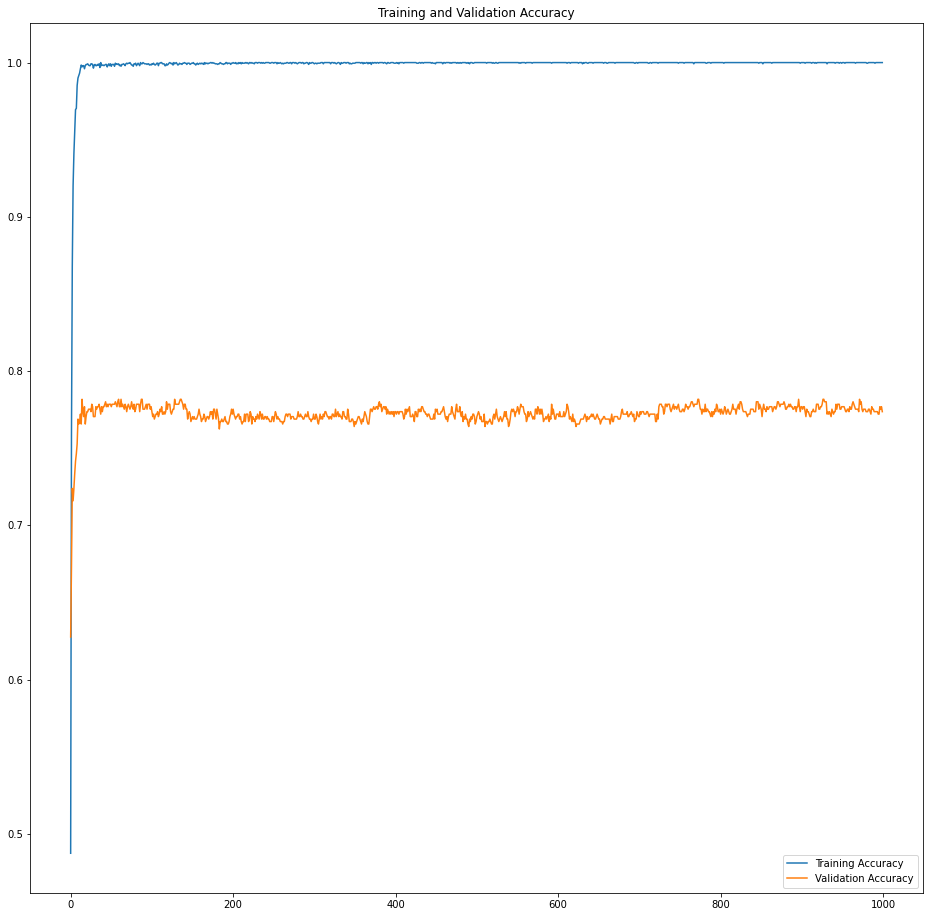

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


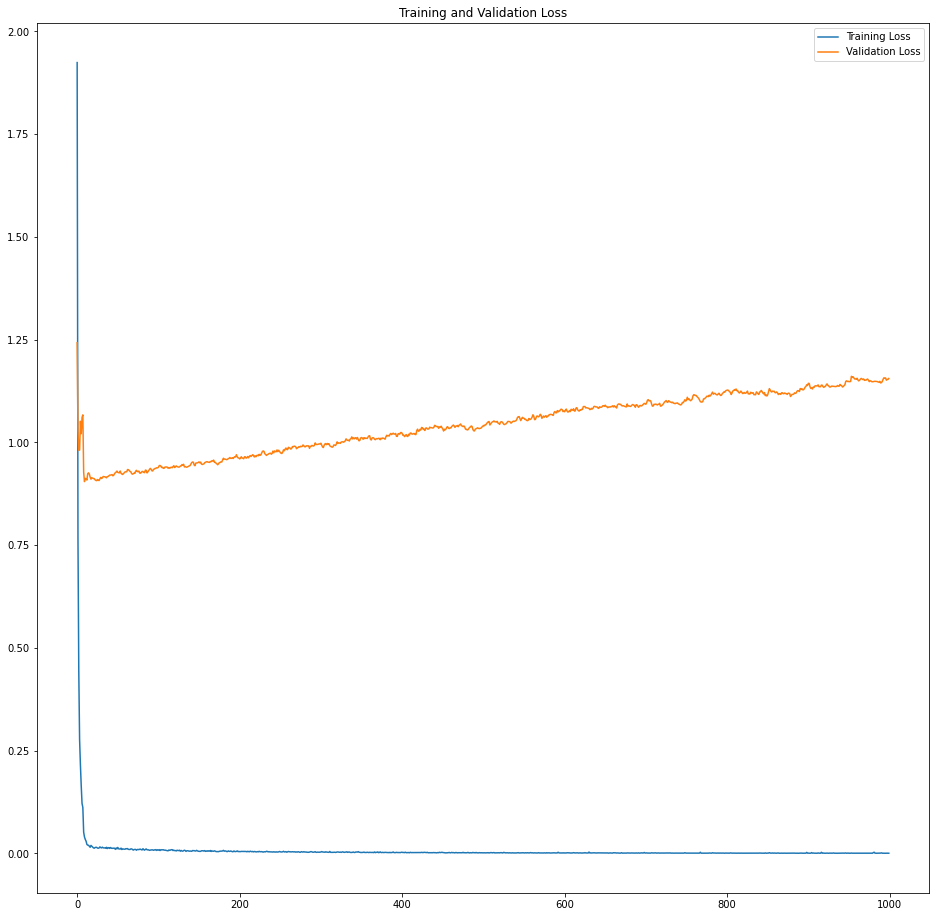

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_ds_results = model.evaluate(test_ds)
print("test_ds_results:test loss, test acc:", test_ds_results)

17/17 [==============================] - 4s 188ms/step - loss: 0.4025 - accuracy: 0.9070
test_ds_results:test loss, test acc: [0.4025173485279083, 0.9069767594337463]


# Testing in Testset

In [31]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['./model/Efficientnetv1EfficientnetB4-epoch0200.pb',
 './model/Efficientnetv1EfficientnetB4-epoch0400.pb',
 './model/Efficientnetv1EfficientnetB4-epoch0600.pb',
 './model/Efficientnetv1EfficientnetB4-epoch0800.pb',
 './model/Efficientnetv1EfficientnetB4-epoch1000.pb']

In [32]:
test_acc = []
test_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    test_results = loaded_model.evaluate(test_ds)
    test_loss.append(test_results[0]) # append loss
    test_acc.append(test_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_acc={test_acc[lm_idx]} \n")

17/17 [==============================] - 5s 150ms/step - loss: 0.3440 - accuracy: 0.8992
Epoch200 
 test_acc=0.8992248177528381 



17/17 [==============================] - 5s 150ms/step - loss: 0.3535 - accuracy: 0.9031
Epoch400 
 test_acc=0.9031007885932922 



17/17 [==============================] - 5s 150ms/step - loss: 0.3785 - accuracy: 0.9031
Epoch600 
 test_acc=0.9031007885932922 



17/17 [==============================] - 5s 150ms/step - loss: 0.3985 - accuracy: 0.9109
Epoch800 
 test_acc=0.9108527302742004 



17/17 [==============================] - 5s 150ms/step - loss: 0.4025 - accuracy: 0.9070
Epoch1000 
 test_acc=0.9069767594337463 



range(200, 1200, 200)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

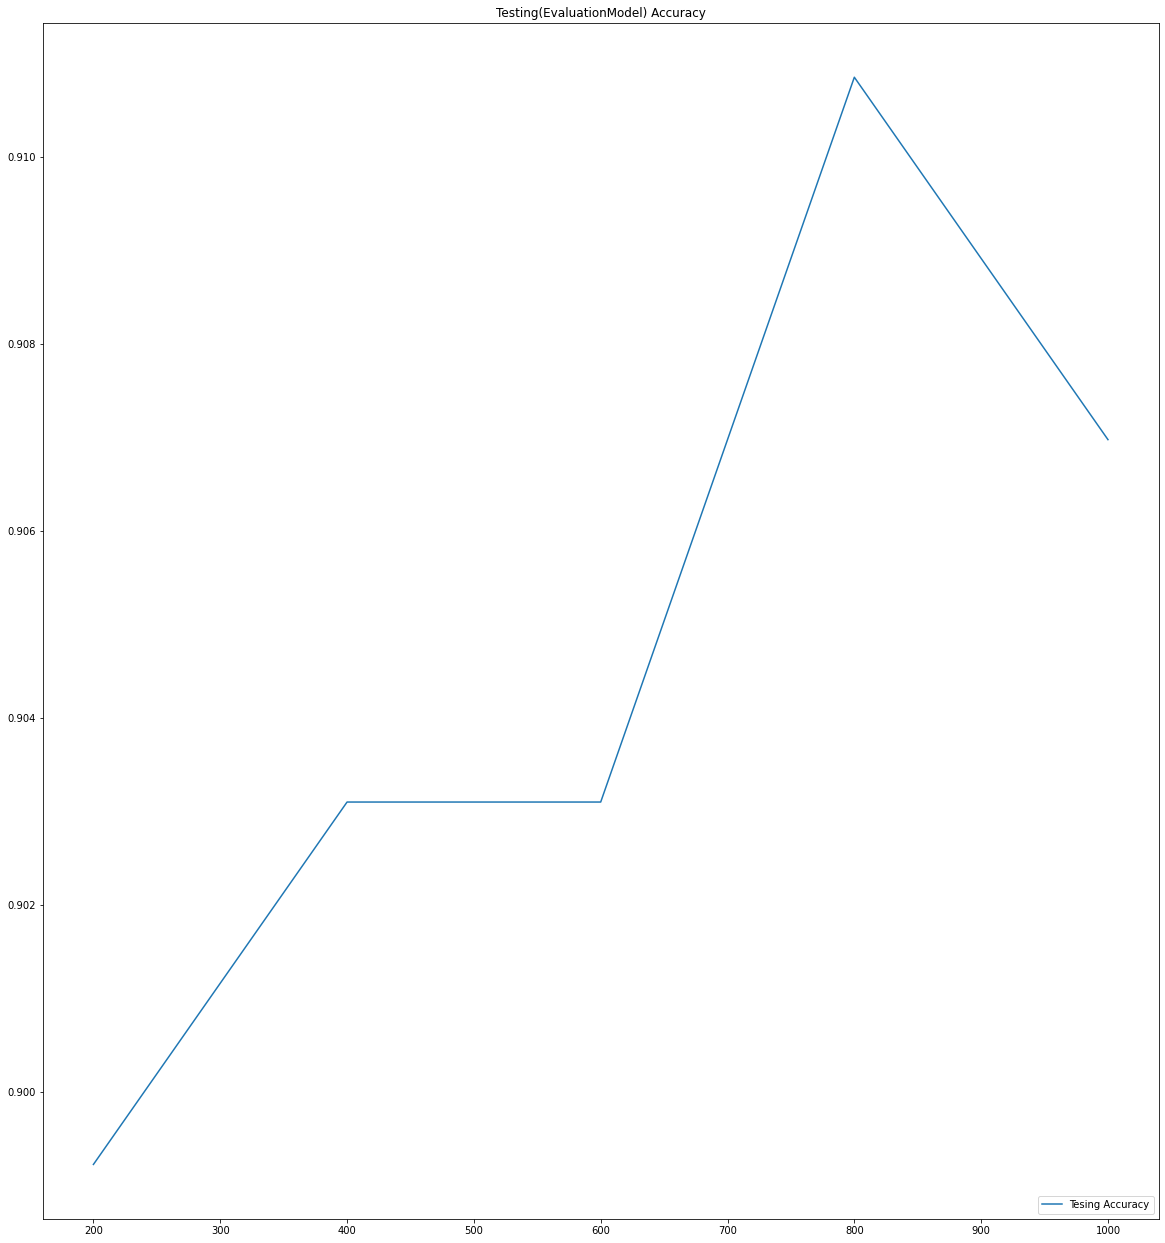

In [33]:
# loss / acc in each epoch graph ploting
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_acc, label='Tesing Accuracy')
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

### Max acc

In [34]:
#Find Max Index and Value
print(f"max acc -> {max(test_acc)}")
max_index = test_acc.index(max(test_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.9108527302742004
max index -> 3
The [Epoch] of max acc -> 800


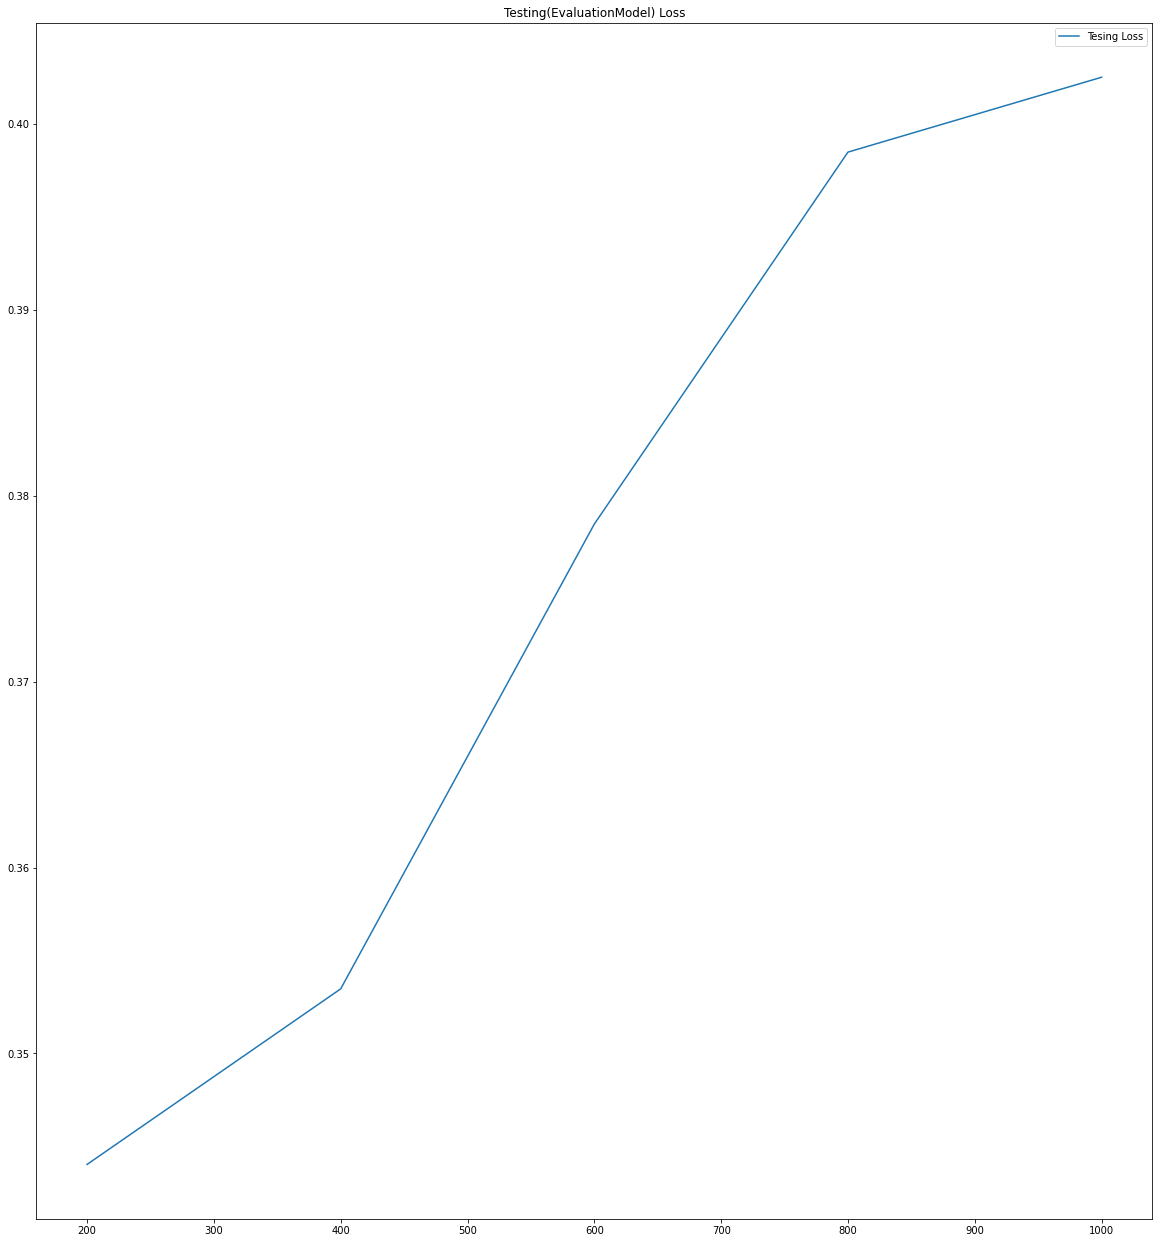

In [35]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_loss, label='Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [36]:
test_acc

[0.8992248177528381,
 0.9031007885932922,
 0.9031007885932922,
 0.9108527302742004,
 0.9069767594337463]

In [37]:
test_loss

[0.34402984380722046,
 0.3534751236438751,
 0.37847989797592163,
 0.3984898626804352,
 0.4025173485279083]

## Load Best Model and Testing in each class

In [38]:
# Del dataset memory and reload best acc model
# RAM
del train_ds
del val_ds

In [39]:
loaded_model = tf.keras.models.load_model(models_paths[max_index])
print(f"Loaded {models_paths[max_index]} (Maximun Acc)")
batch_size=8

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE

x_test = np.concatenate([ x for x,y in test_ds],axis=0)
y_test = np.concatenate([ y for x,y in test_ds],axis=0)

print(f"Amount of testing data x,y : {len(x_test)},{len(y_test)}")

# let's predict
y_all_predicted = loaded_model.predict(x_test,batch_size=batch_size)


Loaded ./model/Efficientnetv1EfficientnetB4-epoch0800.pb (Maximun Acc)
Amount of testing data x,y : 258,258


In [40]:
y_all_predicted_max = np.array([],dtype=np.int32)
# acc all
TP = 0
FP = 0
for i in range(len(y_test)):
    if(y_test[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'All Data = {TP+FP}')
print(f'True Positive = {TP}')
print(f'False Positive = {FP}')
print(f'Accuracy = {TP/(TP+FP)*100} %')

# acc eachclass
TP_eachclass = [0] * len(class_names)
FP_eachclass = [0] * len(class_names)
for i in range(len(y_test)):
    if(y_test[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_test[i]] = TP_eachclass[y_test[i]] + 1
    else :
        FP_eachclass[y_test[i]] = FP_eachclass[y_test[i]] + 1
#recheck
print(f'All number (Processed) = {sum(TP_eachclass)+sum(FP_eachclass)}')

All Data = 258
True Positive = 235
False Positive = 23
Accuracy = 91.08527131782945 %
All number (Processed) = 258


## Accuracy in each class

In [41]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


Ba-Mee-Kiao-Ped-Yang acc = 80.0%
Ba-Mee-Krob-Rat-Na acc = 60.0%
Boiled Chicken Rice acc = 100.0%
Bua-Loi acc = 100.0%
Cherri acc = 100.0%
Kaeo-Mangkon acc = 100.0%
Khai-Hong acc = 100.0%
Khanom-Jeen-Kaeng-Khiao-Wan-Kai acc = 100.0%
Khanom-Jeen-Nam-Ngiao acc = 100.0%
Khanom-Khuai acc = 100.0%
Khanom-Phing acc = 100.0%
Khanta-Lup acc = 100.0%
Khao-Phod acc = 100.0%
Khao-Soi-Kai acc = 40.0%
Khao-Soi-Moo acc = 80.0%
Khao-Tom-Mat acc = 100.0%
KhaoKangKareeGai acc = 100.0%
KhaoKhaMoo acc = 100.0%
KhaoKhaiJeow acc = 80.0%
KhaoKlukKapi acc = 100.0%
KhaoKrapaoMooGrob acc = 100.0%
KhaoKungTodKratiem acc = 80.0%
KhaoMooDaeng acc = 80.0%
KhaokapraomoosubKhaiDow acc = 100.0%
Klauy-Khai acc = 100.0%
Kluai-Buat-Chi acc = 100.0%
Kra-Mae acc = 100.0%
Kuai-Chap acc = 100.0%
Kuai-Tiao-Sen-Lek-Tom-Yum-Moo acc = 100.0%
Kuai-Tiao-Sen-Yai-Rat-Na-Kai acc = 100.0%
Kuai-Tiao-Tom-Yum-Kung acc = 100.0%
Kui-Chai-Thot acc = 100.0%
Malako acc = 100.0%
Nam-Aoi-Sai-Kaew acc = 60.0%
Nam-Coke-Sai-Kaew acc = 60.0%
Nam-Kr

In [42]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
#
confusionMat = confusion_matrix(y_test, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[4, 0, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 5, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 4, 0, 0],
       [0, 0, 0, ..., 0, 5, 0],
       [0, 0, 1, ..., 0, 0, 4]], dtype=int64)

In [43]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[ 80.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,  60.,   0., ...,   0.,   0.,   0.],
       [  0.,   0., 100., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,  80.,   0.,   0.],
       [  0.,   0.,   0., ...,   0., 100.,   0.],
       [  0.,   0.,  20., ...,   0.,   0.,  80.]])

<AxesSubplot:>

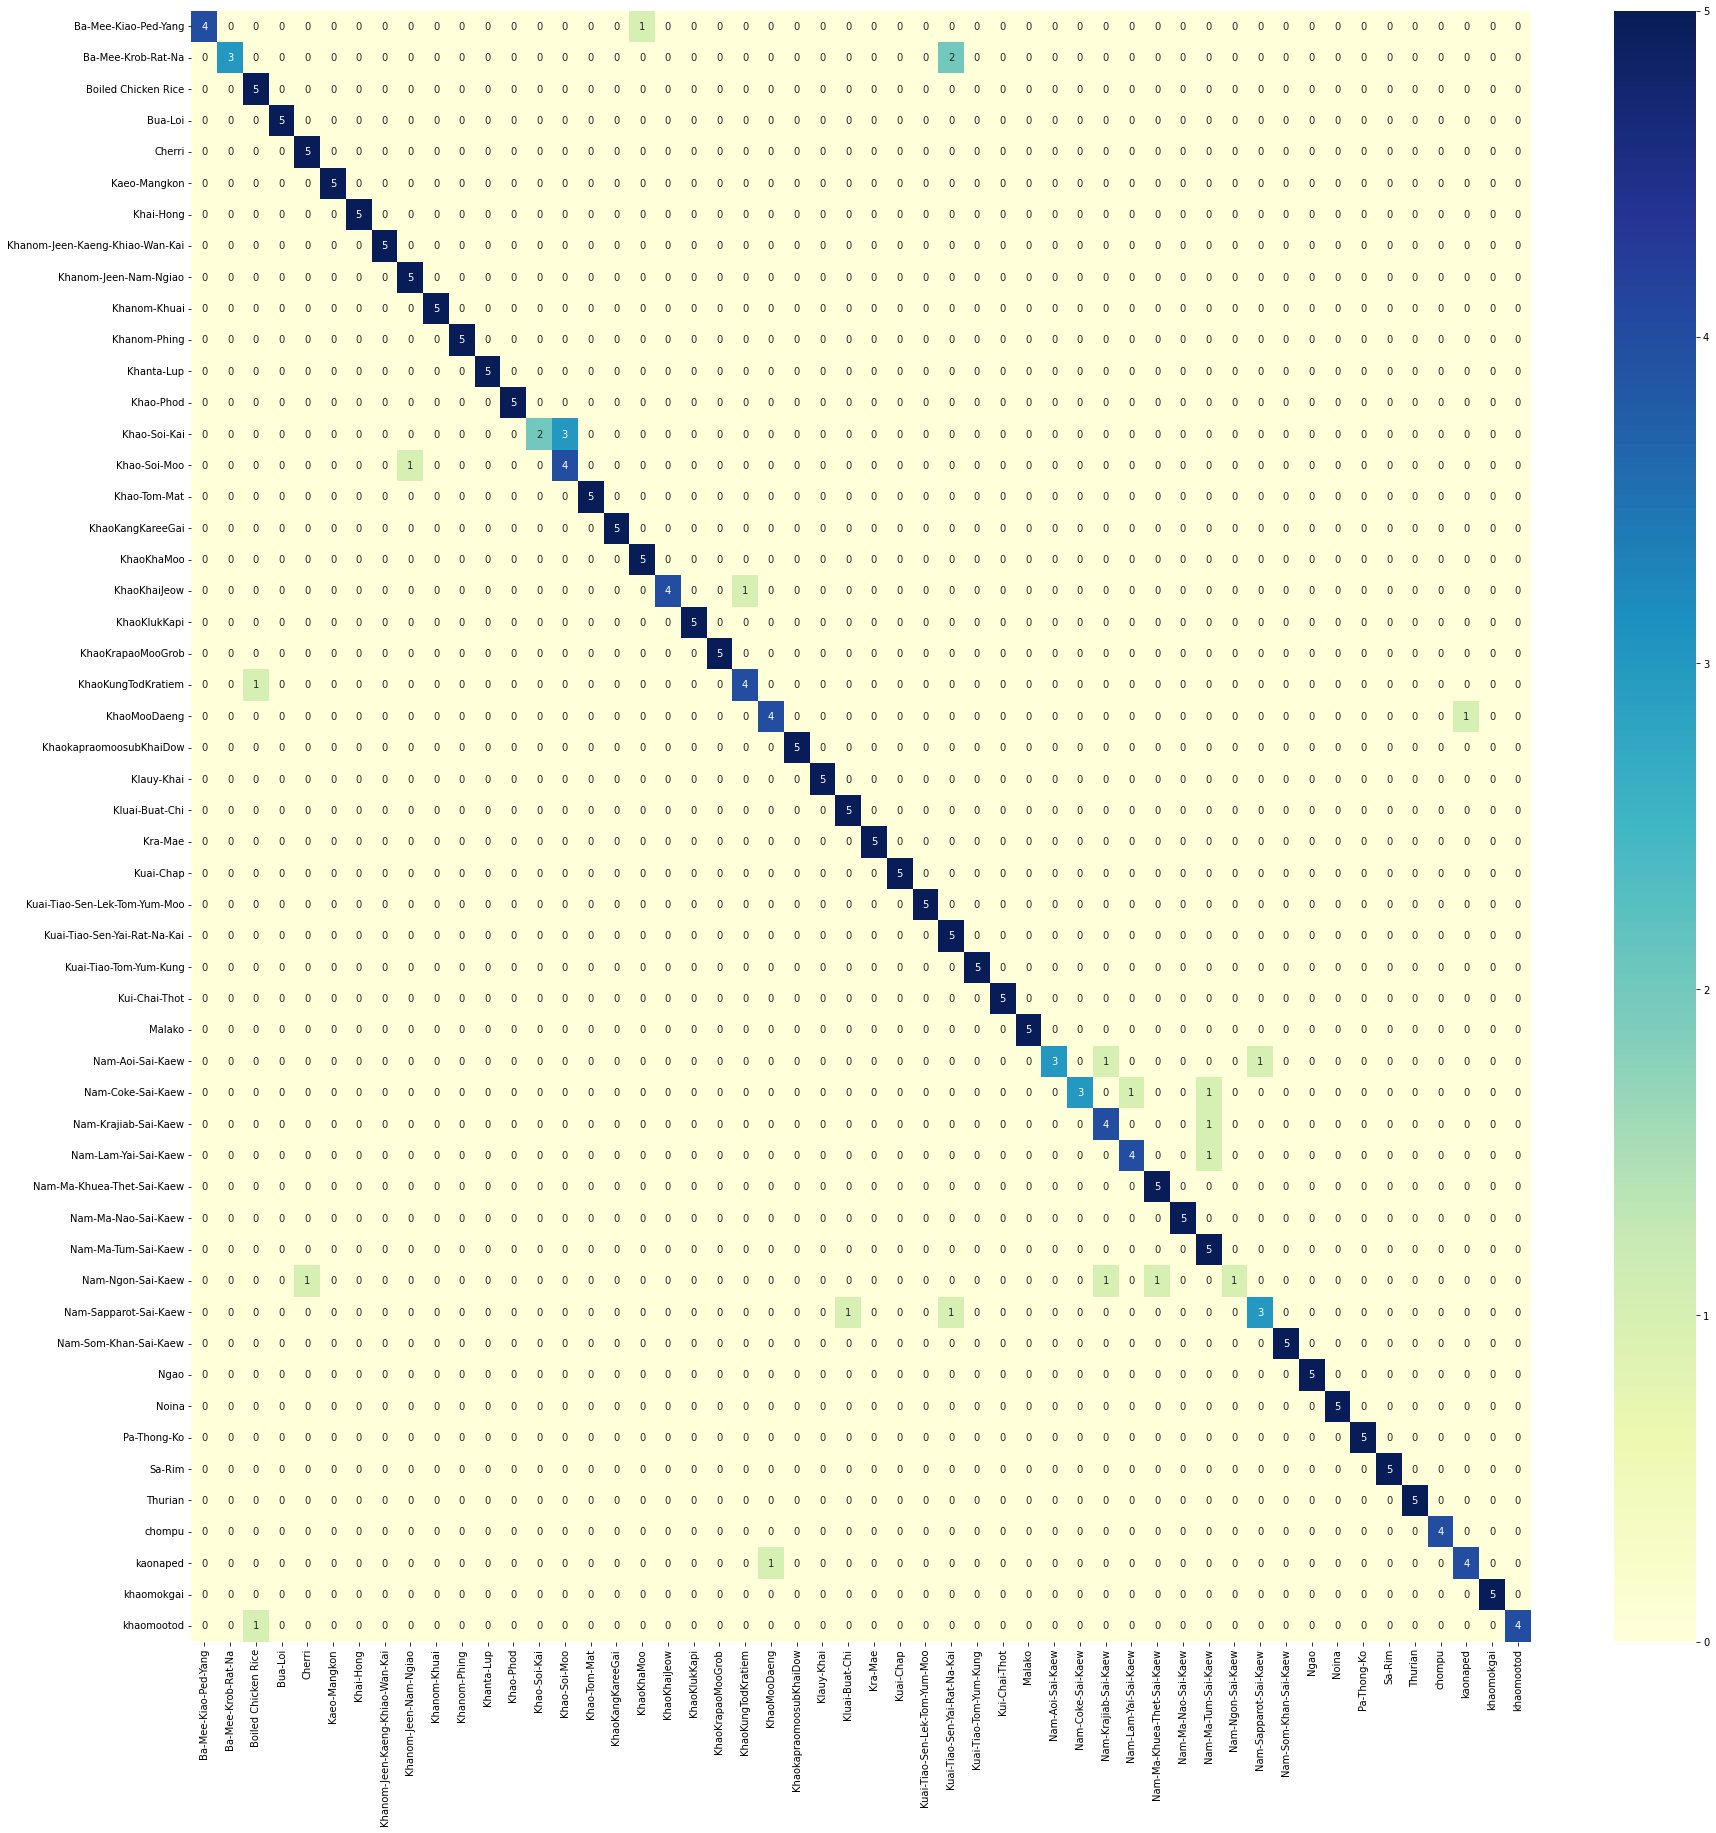

In [50]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

## Plot Confusion Matrix

<AxesSubplot:>

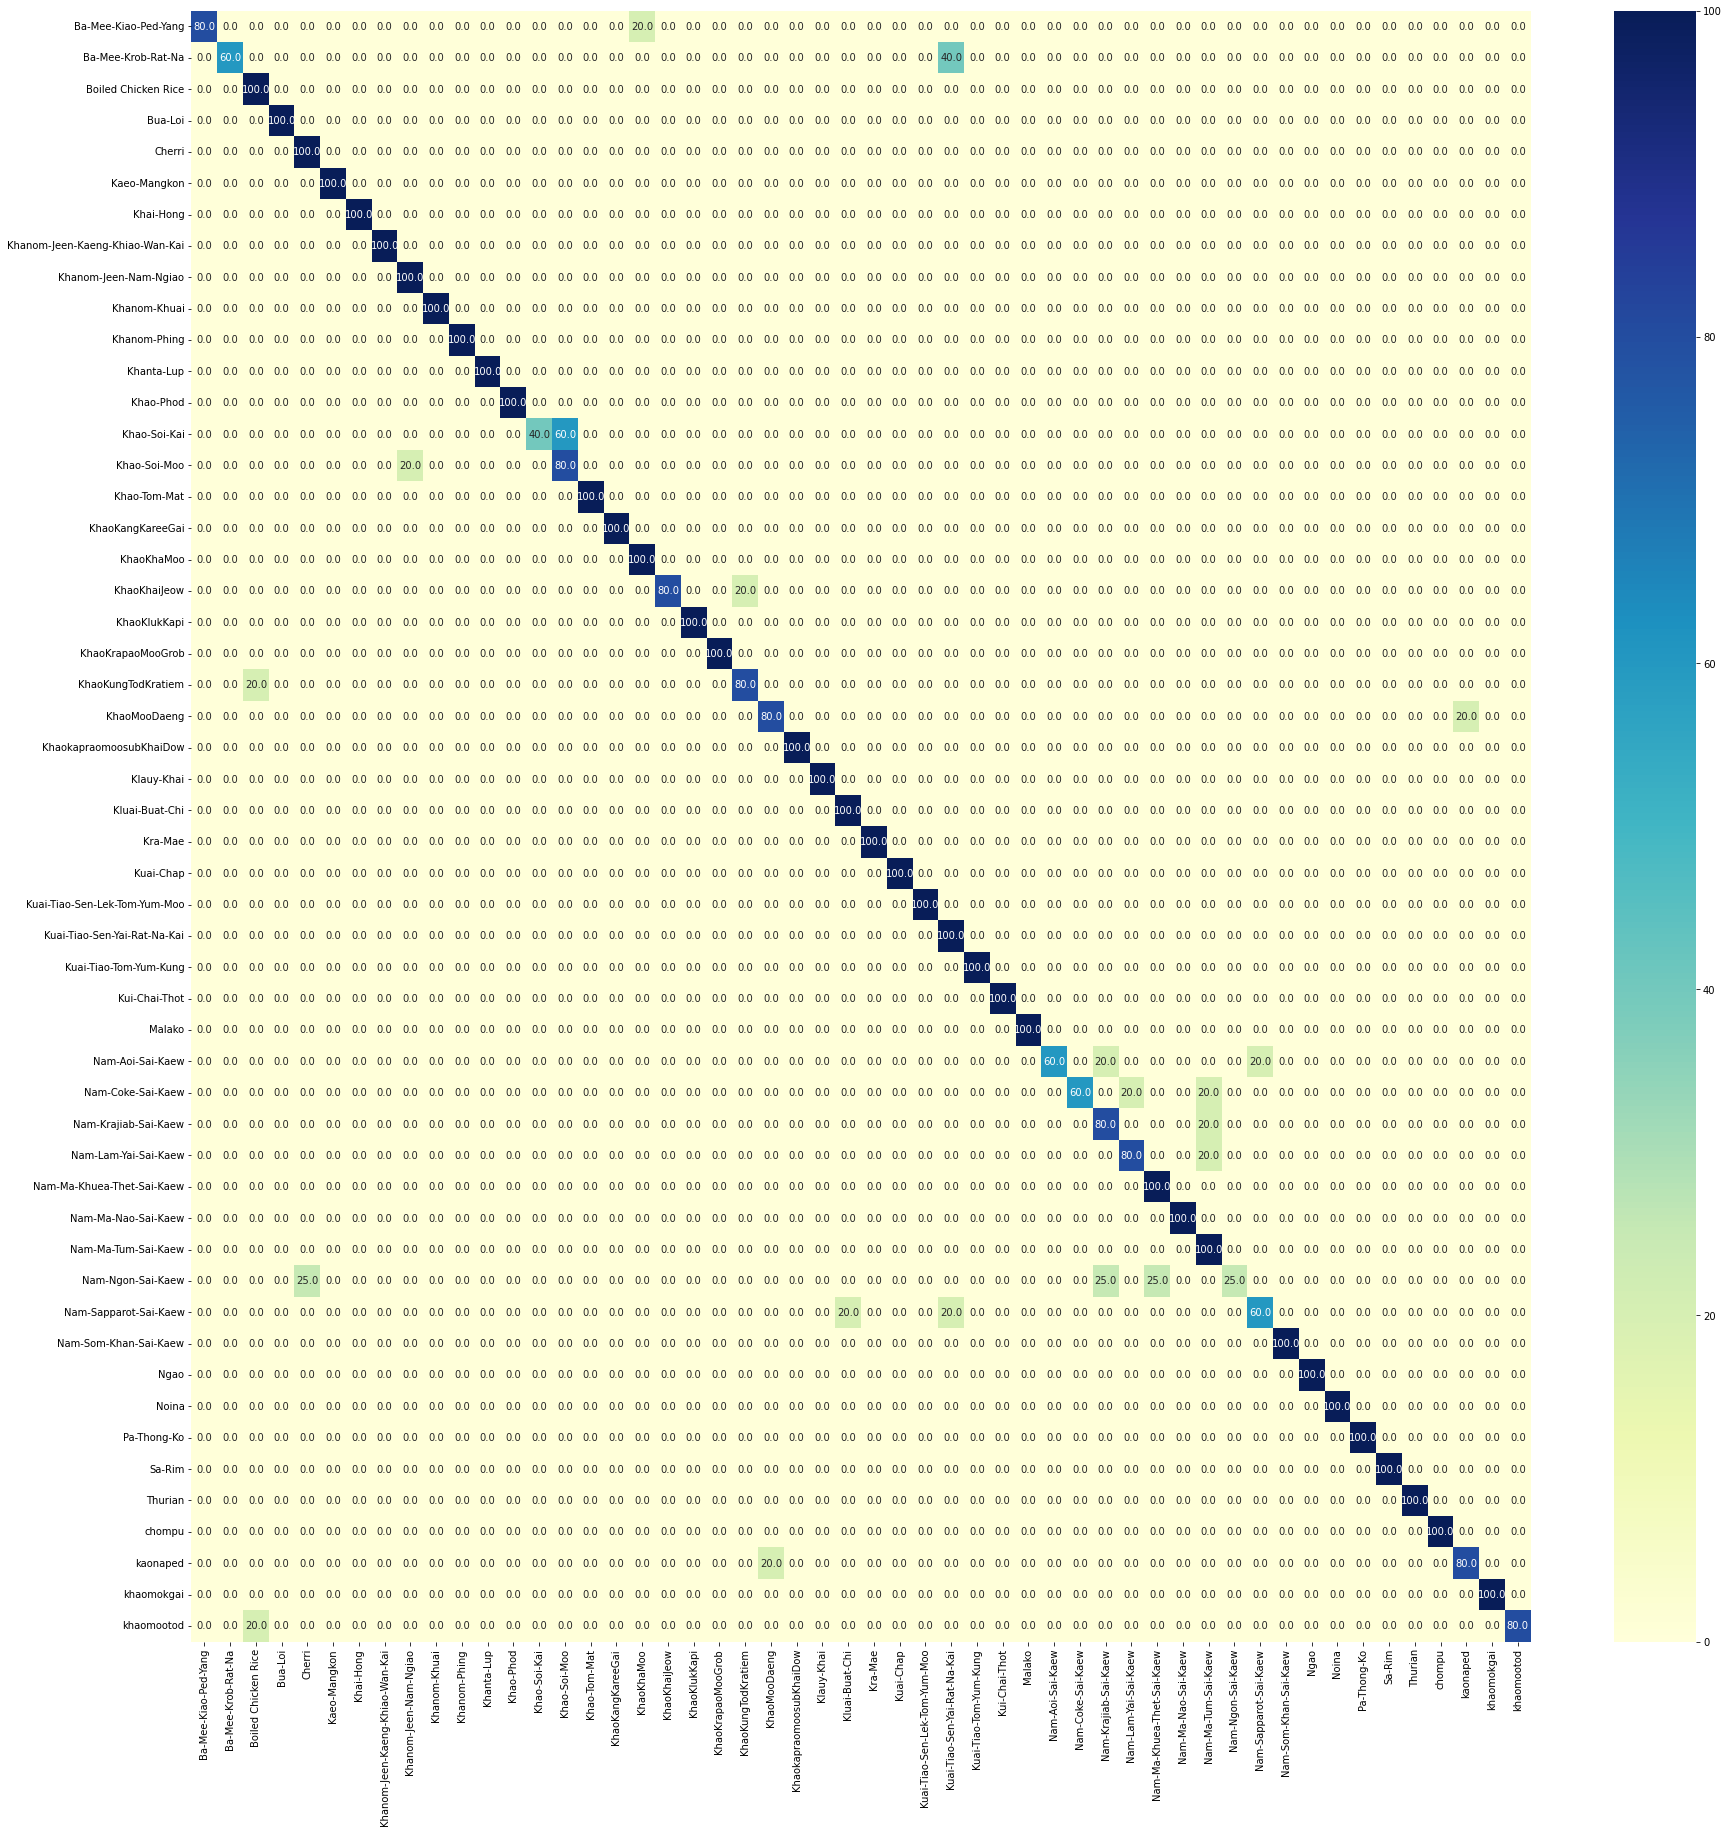

In [51]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".1f")

## Show Predicted Result in Each A Test Image

In [46]:
from PIL import Image
import glob
test_image_paths = glob.glob(test_dataset_path+'**/*.png')

In [47]:
print(test_image_paths)

['./AllFood/test\\Kaeo-Mangkon\\Kaeo-Mangkon (1).png', './AllFood/test\\Kaeo-Mangkon\\Kaeo-Mangkon (6).png', './AllFood/test\\Khao-Phod\\Khao-Phod (1).png', './AllFood/test\\Khao-Phod\\Khao-Phod (5).png', './AllFood/test\\Khao-Soi-Kai\\Khao-Soi-Kai (3).png', './AllFood/test\\Khao-Soi-Moo\\Khao-Soi-Moo (1).png', './AllFood/test\\KhaoKhaiJeow\\KhaoKhaiJeow (1).png', './AllFood/test\\KhaoKrapaoMooGrob\\KhaoKrapaoMooGrob (2).png', './AllFood/test\\Klauy-Khai\\Klauy-Khai (13).png', './AllFood/test\\Klauy-Khai\\Klauy-Khai (4).png', './AllFood/test\\Klauy-Khai\\Klauy-Khai (5).png', './AllFood/test\\Klauy-Khai\\Klauy-Khai (7).png', './AllFood/test\\Kuai-Tiao-Sen-Lek-Tom-Yum-Moo\\Kuai-Tiao-Sen-Lek-Tom-Yum-Moo (4).png', './AllFood/test\\Kuai-Tiao-Tom-Yum-Kung\\Kuai-Tiao-Tom-Yum-Kung (1).png', './AllFood/test\\Kui-Chai-Thot\\Kui-Chai-Thot (1).png', './AllFood/test\\Kui-Chai-Thot\\Kui-Chai-Thot (6).png', './AllFood/test\\Kui-Chai-Thot\\Kui-Chai-Thot (7).png', './AllFood/test\\Malako\\Malako (3).pn

*** Warning : Answer will not same the test_ds, that loaded by tensorflow, because below code load / resize image by using different algorithm.

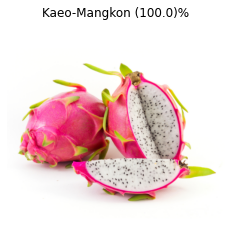

_________________________________________


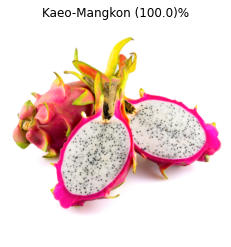

_________________________________________


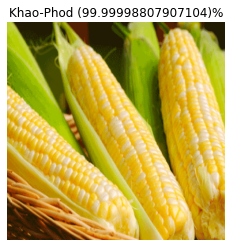

_________________________________________


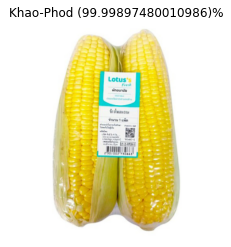

_________________________________________


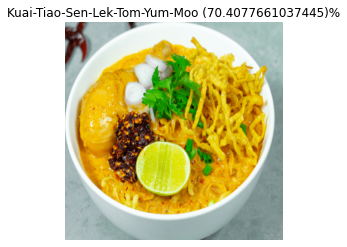

_________________________________________


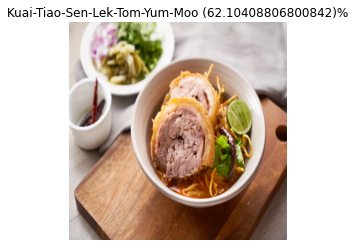

_________________________________________


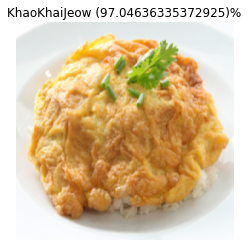

_________________________________________


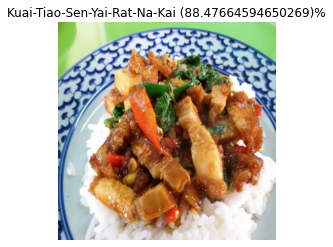

_________________________________________


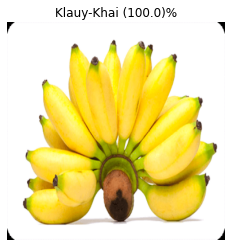

_________________________________________


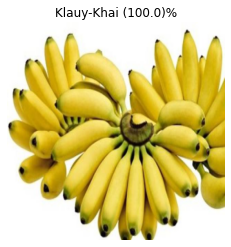

_________________________________________


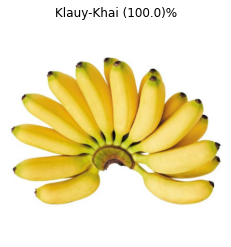

_________________________________________


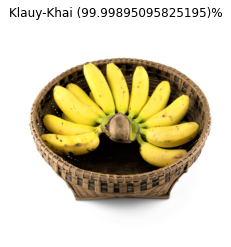

_________________________________________


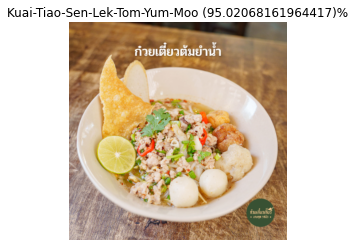

_________________________________________


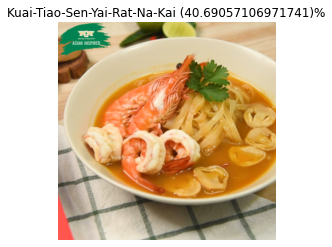

_________________________________________


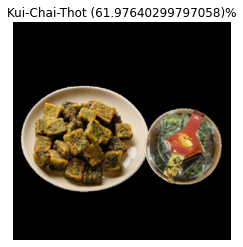

_________________________________________


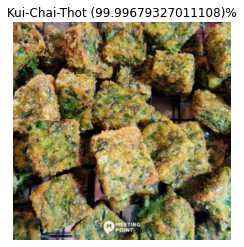

_________________________________________


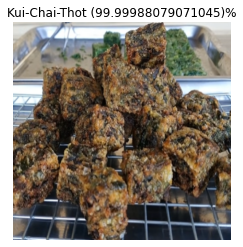

_________________________________________


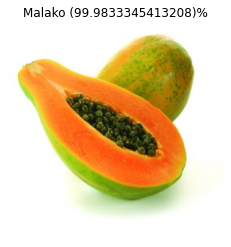

_________________________________________


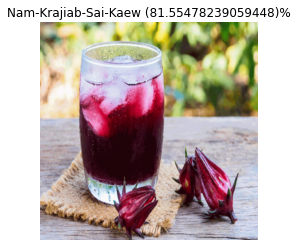

_________________________________________


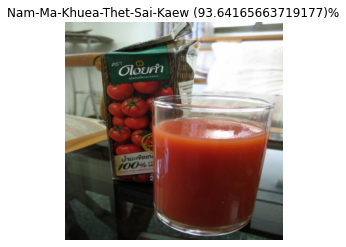

_________________________________________


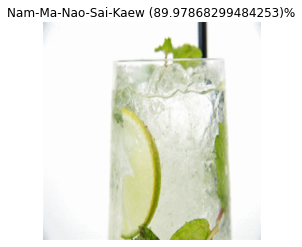

_________________________________________


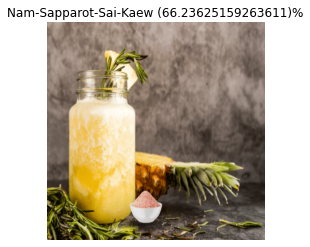

_________________________________________


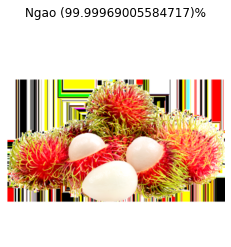

_________________________________________


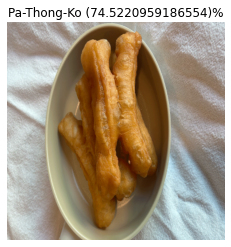

_________________________________________


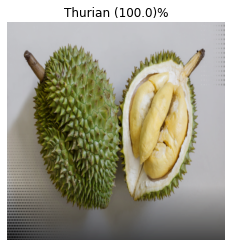

_________________________________________


In [48]:
import cv2 as cv
for i,test_image_path in enumerate(test_image_paths):
  cvImg = cv.imread(test_image_path)
  cvImg = cv.resize(cvImg,(img_width,img_height),interpolation=cv.INTER_AREA) # custom interpolation
  img_array = np.array(cvImg) # convert 2 np array
  # img_array = img_array/255.0 # uncomment if must be normalize image by 255.0
  img_array_expanded = np.expand_dims(img_array, axis=0) # Expand dimensions to match the 4D Tensor shape.
  ans = loaded_model.predict(img_array_expanded)
  max_ans = np.argmax(ans)
  max_conf = np.max(ans)*100.0
  plt.axis("off")
  plt.imshow(cv.cvtColor(cvImg, cv.COLOR_BGR2RGB))
  plt.title(class_names[max_ans]+' ('+str(max_conf)+')'+'%')
  plt.show()
  print('_________________________________________')
